# Iris Species Classification - Julia

1. [Introduction](#1)
2. [Data Preparation](#2)
3. [Evaluation Metrics](#3)
4. [Modeling](#4)
   - 4.1 [Decision Tree](#41)
   - 4.2 [Naïve Bayes](#42)
   - 4.3 [AdaBoost](#43)
   - 4.4 [Perceptron](#44)
   - 4.5 [Random forests](#45)
5. [Conclusion](#5)

## 1. Introduction <a id=1></a>

The [dataset](https://www.kaggle.com/uciml/iris) includes three iris species with 50 samples each as well as some properties about each flower. One flower species is linearly separable from the other two, but the other two are not linearly separable from each other.
Iris dataset includes 4 properties column and 1 label column:
| Column | Description |
| :- | :- |
| SepalLengthCm | Sepal Length given in cm |
| SepalWidthCm | Sepal Width given in cm |
| PetalLengthCm | Petal Length given in cm |
| PetalWidthCm | Petal Width given in cm |
| Species | The label value, takes one of three values (Iris-setosa / Iris-versicolor / Iris-virginica) |

We are going to build a machine learning model to accurately predict the species of the flower based on its sepal and petal dimensions.

## 2. Data Preparation <a id=2></a>

In [71]:
using mlpack
using DataFrames
using RDatasets
using Random
using Plots
using MLJ

In [72]:
# get the dataset and drop duplicate items
df = unique(RDatasets.dataset("datasets", "iris"))
# take a look at the first 5 rows
print(df[1:5,:])

5×5 DataFrame
 Row │ SepalLength  SepalWidth  PetalLength  PetalWidth  Species 
     │ Float64      Float64     Float64      Float64     Cat…    
─────┼───────────────────────────────────────────────────────────
   1 │         5.1         3.5          1.4         0.2  setosa
   2 │         4.9         3.0          1.4         0.2  setosa
   3 │         4.7         3.2          1.3         0.2  setosa
   4 │         4.6         3.1          1.5         0.2  setosa
   5 │         5.0         3.6          1.4         0.2  setosa

In [73]:
# split features and targets to x, y
x = df[:, 1:size(df)[2]-1]
y = df[:, size(df)[2]]
# recode the label from string to integer
unique_labels = unique(y)
str2int = Dict(zip(unique_labels, range(1, length(unique_labels))))
y = map(t -> str2int[t], y);
print(str2int)

Dict("virginica" => 3, "setosa" => 1, "versicolor" => 2)

## 3. Evaluation Metrics <a id=3></a>

first we write a helper function to split the dataset into training and test set

In [74]:
function TrainTestSplit(features, target, test_ratio=0.2, standardize=false)
    """
    Splits the features & target into respective training and test set based on the test ratio.

        Parameter:
            features (DataFrame or Matrix): dataframe containing the features.
            target (DataFrame or Vector): dataframe containing the targets.
            test_ratio (double): Percentage of dataset to be hold out for test set. default 20%.
            standardize (bool): if True, features are scaled, default False.

        Returns:
            Xtrain (DataFrame):  Matrix containing training features.
            Xtest (DataFrame):  Matrix containing test features.
            ytrain (DataFrame):  Vector containing training targets.
            ytest (DataFrame):  Vector containing test targets.
    """
    total = size(features)[1]
    idx = shuffle(collect(1:total))
    split_point = Int(floor(total * test_ratio))
    xtest = features[idx[1:split_point], :]
    xtrain = features[idx[split_point+1:end], :]
    ytest = target[idx[1:split_point]]
    ytrain = target[idx[split_point+1:end]]
    xtrain, xtest, ytrain, ytest = Matrix(xtrain), Matrix(xtest), Vector(ytrain), Vector(ytest)
    if standardize
        xtrain, xtest = Standardizer(xtrain), Standardizer(xtest)
    end
    return xtrain, xtest, ytrain, ytest
end

TrainTestSplit (generic function with 3 methods)

### Let's use Confusion Matrix to evaluate our model
* True Positive - The actual value was true & the model predicted true.
* False Positive - The actual value was false & the model predicted true, Type I error.
* True Negative - The actual value was false & the model predicted false.
* False Negative - The actual value was true & the model predicted false, Type II error.

`Accuracy`: is a metric that generally describes how the model performs across all classes. It is useful when all classes are of equal importance. It is calculated as the ratio between the number of correct predictions to the total number of predictions.

$$Accuracy = \frac{True_{positive} + True_{negative}}{True_{positive} + True_{negative} + False_{positive} + False_{negative}}$$

`Precision`: is calculated as the ratio between the number of positive samples correctly classified to the total number of samples classified as Positive. The precision measures the model's accuracy in classifying a sample as positive.

$$Precision = \frac{True_{positive}}{True_{positive} + False_{positive}}$$

`Recall`: is calulated as the ratio between the number of positive samples correctly classified as Positive to the total number of Positive samples. The recall measures the model's ability to detect Positive samples. The higher the recall, the more positive samples detected.

$$Recall = \frac{True_{positive}}{True_{positive} + False_{negative}}$$

`Confusion matrix`: A technique used for summarizing the performance of a classification algorithm. 

![](https://cdn-images-1.medium.com/max/1600/0*-GAP6jhtJvt7Bqiv.png)


* The decision of whether to use precision or recall depends on the type of problem begin solved.
* If the goal is to detect all positive samples then use recall.
* Use precision if the problem is sensitive to classifying a sample as Positive in general.

In [75]:
function print_metrics(yPreds, ytest)
    fs = MLJ.MulticlassFScore()(yPreds, ytest)
    fn = MLJ.MulticlassFalseNegativeRate()(yPreds, ytest)
    fp = MLJ.MulticlassFalsePositiveRate()(yPreds, ytest)
    tn = MLJ.MulticlassTrueNegativeRate()(yPreds, ytest)
    tp = MLJ.MulticlassTruePositiveRate()(yPreds, ytest)
    acc = (tp + tn) / (tp + tn + fp + fn)
    pre = tp / (tp + fp)
    rc = tp / (tp + fn)
    println("Accuracy: $(acc)")
    println("Recall: $(rc)")
    println("Precision: $(pre)")
end
function plot_confusion_matrix(cm, ul)
    heatmap(cm, xticks=(1:length(ul), ul), yticks=(1:length(ul), ul), fc=cgrad([:white, :dodgerblue4]))
    annotate!([(j, i, text(cm[i, j], 8)) for i in 1:length(ul) for j in 1:length(ul)])
    ylabel!("Predicted")
    xlabel!("Ground Truth")
end

plot_confusion_matrix (generic function with 1 method)

## 4. Modeling <a id=4></a>

In [76]:
# first we randomly split the data set
Xtrain, Xtest, ytrain, ytest = TrainTestSplit(x, y)

([6.3 3.3 4.7 1.6; 5.7 2.5 5.0 2.0; … ; 5.7 3.0 4.2 1.2; 6.9 3.1 5.4 2.1], [6.9 3.1 4.9 1.5; 6.4 3.2 5.3 2.3; … ; 4.3 3.0 1.1 0.1; 5.1 3.5 1.4 0.2], [2, 3, 1, 1, 2, 3, 3, 2, 1, 1  …  1, 3, 3, 2, 1, 3, 3, 3, 2, 3], [2, 3, 2, 3, 2, 2, 1, 2, 1, 1  …  1, 3, 3, 2, 3, 3, 2, 2, 1, 1])

### 4.1 Decision Tree <a id=41></a>

In [77]:
dt_model, _, _ = mlpack.decision_tree(training=(fill(false, (size(Xtrain)[1])), Xtrain), labels=ytrain)
_, yPreds = mlpack.decision_tree(input_model=dt_model, test=(fill(false, (size(Xtest)[1])), Xtest))
print_metrics(yPreds, ytest)
cm = MLJ.confusion_matrix(yPreds, ytest)

Accuracy: 0.9236842105263158
Recall: 0.9
Precision: 0.9447513812154695


          ┌──────────────┐
          │ Ground Truth │
┌─────────┼────┬────┬────┤
│Predicted│ 1  │ 2  │ 3  │
├─────────┼────┼────┼────┤
│    1    │ 9  │ 0  │ 0  │
├─────────┼────┼────┼────┤
│    2    │ 0  │ 7  │ 0  │
├─────────┼────┼────┼────┤
│    3    │ 0  │ 3  │ 10 │
└─────────┴────┴────┴────┘


Accuracy: 0.9236842105263158
Recall: 0.9
Precision: 0.9447513812154695


┌ Warning: Levels not explicitly ordered. Using the order [1, 2, 3]. 
└ @ StatisticalMeasures.ConfusionMatrices /home/xinyu/.julia/packages/StatisticalMeasures/hPDX2/src/confusion_matrices.jl:339


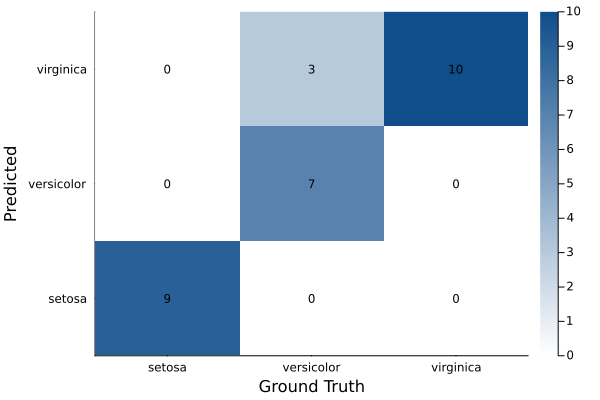

In [78]:
print_metrics(yPreds, ytest)
plot_confusion_matrix(ConfusionMatrices.matrix(cm), unique_labels)

### 4.2 Naïve Bayes <a id=42></a>

In [79]:
_, nbc_model, _, _, _ = mlpack.nbc(training=Xtrain, labels=ytrain)
yPreds, _, _, _, _ = mlpack.nbc(input_model=nbc_model, test=Xtest)
print_metrics(yPreds, ytest)
cm = MLJ.confusion_matrix(yPreds, ytest)

Accuracy: 0.9236842105263158
Recall: 0.9
Precision: 0.9447513812154695


          ┌──────────────┐
          │ Ground Truth │
┌─────────┼────┬────┬────┤
│Predicted│ 1  │ 2  │ 3  │
├─────────┼────┼────┼────┤
│    1    │ 9  │ 0  │ 0  │
├─────────┼────┼────┼────┤
│    2    │ 0  │ 7  │ 0  │
├─────────┼────┼────┼────┤
│    3    │ 0  │ 3  │ 10 │
└─────────┴────┴────┴────┘


Accuracy: 0.9236842105263158
Recall: 0.9
Precision: 0.9447513812154695


┌ Warning: Levels not explicitly ordered. Using the order [1, 2, 3]. 
└ @ StatisticalMeasures.ConfusionMatrices /home/xinyu/.julia/packages/StatisticalMeasures/hPDX2/src/confusion_matrices.jl:339


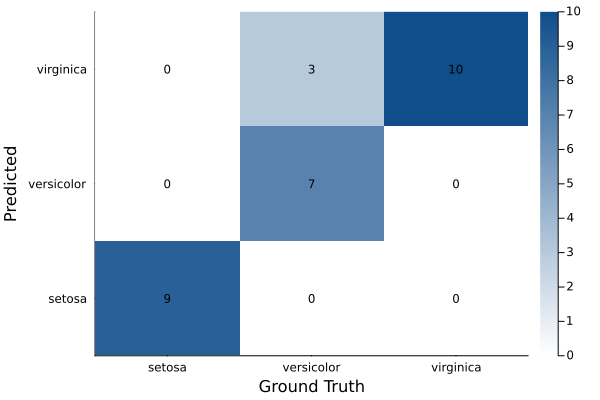

In [80]:
print_metrics(yPreds, ytest)
plot_confusion_matrix(ConfusionMatrices.matrix(cm), unique_labels)

### 4.3 AdaBoost <a id=43></a>

In [81]:
_, ada_model, _, _ = mlpack.adaboost(labels=ytrain, training=Xtrain, weak_learner="decision_stump")
_, _, yPreds, _ = mlpack.adaboost(input_model=ada_model, test=Xtest)
print_metrics(yPreds, ytest)
cm = MLJ.confusion_matrix(yPreds, ytest)

[INFO ] 3 classes in dataset.
Accuracy: 0.9491228070175439
Recall: 0.9333333333333333
Precision: 0.9637681159420289


          ┌──────────────┐
          │ Ground Truth │
┌─────────┼────┬────┬────┤
│Predicted│ 1  │ 2  │ 3  │
├─────────┼────┼────┼────┤
│    1    │ 9  │ 0  │ 0  │
├─────────┼────┼────┼────┤
│    2    │ 0  │ 8  │ 0  │
├─────────┼────┼────┼────┤
│    3    │ 0  │ 2  │ 10 │
└─────────┴────┴────┴────┘


Accuracy: 0.9491228070175439
Recall: 0.9333333333333333
Precision: 0.9637681159420289


┌ Warning: Levels not explicitly ordered. Using the order [1, 2, 3]. 
└ @ StatisticalMeasures.ConfusionMatrices /home/xinyu/.julia/packages/StatisticalMeasures/hPDX2/src/confusion_matrices.jl:339


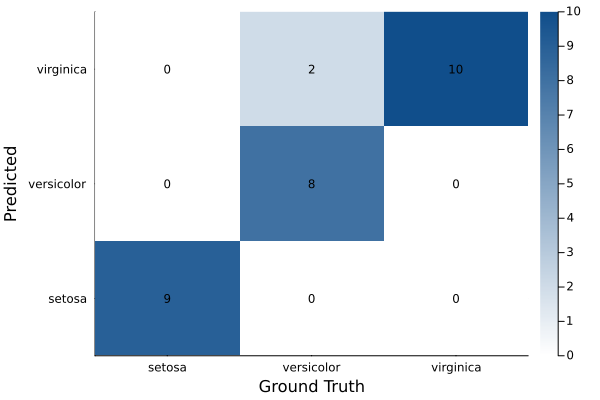

In [82]:
print_metrics(yPreds, ytest)
plot_confusion_matrix(ConfusionMatrices.matrix(cm), unique_labels)

### 4.4 Perceptron (a single level neural network) <a id=44></a>

In [83]:
_, NN_model, _ = mlpack.perceptron(training=Xtrain, labels=ytrain)
_, _, yPreds = mlpack.perceptron(input_model=NN_model, test=Xtest)
print_metrics(yPreds, ytest)
cm = MLJ.confusion_matrix(yPreds, ytest)

[INFO ] Training perceptron on dataset '4x120 matrix' with labels in '1x120 matrix' for a maximum of 1000 iterations.
[INFO ] Using saved perceptron from PerceptronModel model at 0x10e02f0.
[INFO ] Classifying dataset '4x29 matrix'.
Accuracy: 0.9491228070175439
Recall: 0.9333333333333333
Precision: 0.9637681159420289


          ┌──────────────┐
          │ Ground Truth │
┌─────────┼────┬────┬────┤
│Predicted│ 1  │ 2  │ 3  │
├─────────┼────┼────┼────┤
│    1    │ 9  │ 0  │ 0  │
├─────────┼────┼────┼────┤
│    2    │ 0  │ 8  │ 0  │
├─────────┼────┼────┼────┤
│    3    │ 0  │ 2  │ 10 │
└─────────┴────┴────┴────┘


Accuracy: 0.9491228070175439
Recall: 0.9333333333333333
Precision: 0.9637681159420289


┌ Warning: Levels not explicitly ordered. Using the order [1, 2, 3]. 
└ @ StatisticalMeasures.ConfusionMatrices /home/xinyu/.julia/packages/StatisticalMeasures/hPDX2/src/confusion_matrices.jl:339


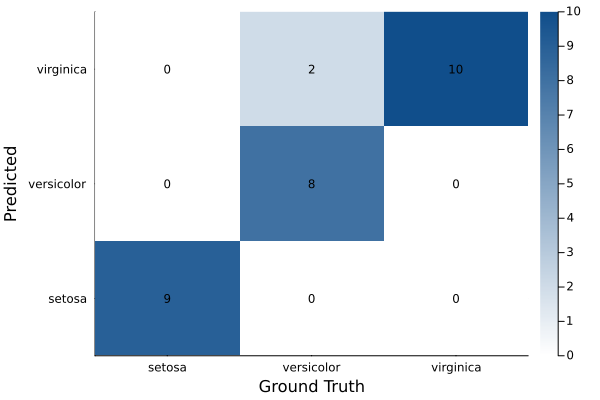

In [84]:
print_metrics(yPreds, ytest)
plot_confusion_matrix(ConfusionMatrices.matrix(cm), unique_labels)

### 4.5 Random forests <a id=45></a>

In [85]:
rf_model, _, _ = mlpack.random_forest(labels=ytrain, training=Xtrain)
_, yPreds, _ = mlpack.random_forest(input_model=rf_model, test=Xtest)
print_metrics(yPreds, ytest)
cm = MLJ.confusion_matrix(yPreds, ytest)

[INFO ] Training random forest with 10 trees...
Accuracy: 0.9491228070175439
Recall: 0.9333333333333333
Precision: 0.9637681159420289


          ┌──────────────┐
          │ Ground Truth │
┌─────────┼────┬────┬────┤
│Predicted│ 1  │ 2  │ 3  │
├─────────┼────┼────┼────┤
│    1    │ 9  │ 0  │ 0  │
├─────────┼────┼────┼────┤
│    2    │ 0  │ 8  │ 0  │
├─────────┼────┼────┼────┤
│    3    │ 0  │ 2  │ 10 │
└─────────┴────┴────┴────┘


Accuracy: 0.9491228070175439
Recall: 0.9333333333333333
Precision: 0.9637681159420289


┌ Warning: Levels not explicitly ordered. Using the order [1, 2, 3]. 
└ @ StatisticalMeasures.ConfusionMatrices /home/xinyu/.julia/packages/StatisticalMeasures/hPDX2/src/confusion_matrices.jl:339


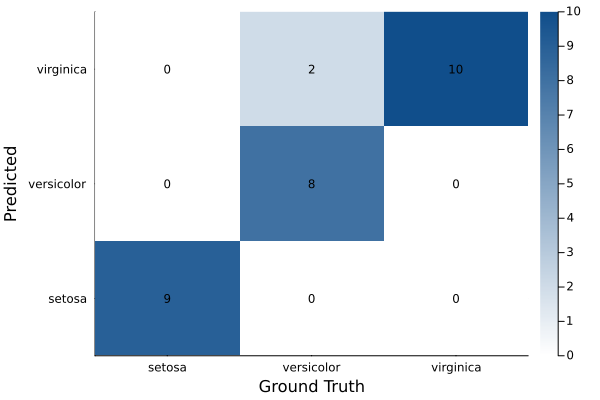

In [86]:
print_metrics(yPreds, ytest)
plot_confusion_matrix(ConfusionMatrices.matrix(cm), unique_labels)

## 5. Conclusion <a id=5></a>

As we can see all the 5 models used in this notebook perform quite similarly on this dataset.

- **Accuracy:** Generally above 0.9

Keep in mind that this dataset is very small (150 entries) so the results change every time you run the notebook